## 180 Final Project : Chinese License Plate Recognization

Yaoyuan Shi & Yixue Zhao

# Import package

In [1]:
import pandas as pd
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models

import albumentations
from albumentations.pytorch import ToTensorV2

# Define transformation

The process below is using albumentation to help improve the quality of the images and transform the image to better brake down and transform to a form that can be train and recognize. 

In [2]:
trans = albumentations.Compose([
        albumentations.Resize(70, 200),
        albumentations.RandomBrightnessContrast(),
        albumentations.GridDistortion(p=.5, distort_limit=0.15, num_steps=5),
        albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
])

# Data example
Here we need to import image from the dataset and show the image as an example.

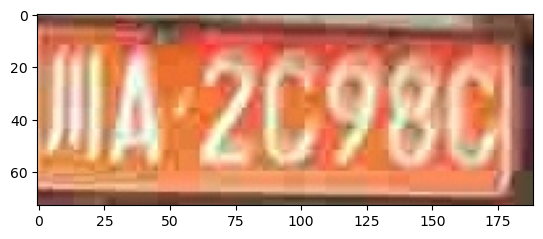

In [3]:
img = cv2.imread('./dataset/train/川A2C98C.jpg')
plt.imshow(img)

In [4]:
paths = glob.glob('./dataset/train/*')
labls = [x.split('/')[-1][:-4] for x in paths]

In [5]:
''.join(set(''.join(labls)))

'1沪津T黑9G吉桂湘川渝贵36WP4辽R蒙EX7鄂0D云M青Z皖鲁闽QU苏晋JL浙KNYV冀AS8C陕5粤B新2豫甘赣京HF'

In [6]:
len(''.join(list(set(''.join(labls))))) # total of 62 characters/numbers

62

# Pytorch dataset
In this process we use Pytorch to classify the dataset from the dataset file and define each functions. Since all the Chinese Car License plate are fixed at 7 characters. That will be easier for us to fix the length. 

In [8]:
class CarDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, img_paths, lbl_dict, transform, label=True):
        self.img_paths = img_paths
        self.lbl_dict = lbl_dict
        self.label = label
        self.transform = transform
        self.len = len(img_paths)

    def read_img(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def __getitem__(self, index):

        img = self.read_img(self.img_paths[index])

        augmented = self.transform(image=img)
        img = augmented['image']
        img_label = self.img_paths[index].split('/')[-1][:-4]

        label_list = []
        if self.label:
            for i in range(7):
                label_list.append(torch.from_numpy(np.array(self.lbl_dict.find(img_label[i]))))

            return img, label_list
        else:
            return img

    def __len__(self):
        return self.len

NameError: name 'torch' is not defined

# Pytorch Model
Pretrain the image by using resnet, and make sure to run the rest of the cell by GPU, and the Trainning and Test Process will usually take about 15 mins 

In [8]:
base_model = torch.nn.Sequential(*(list(models.resnet18(True).children())[:-1]))

class CarNet(nn.Module):
    def __init__(self):
        super(CarNet, self).__init__()

        self.fc = [nn.Linear(512, 62).cuda() for _ in range(7)]
        self.resnet = base_model

    def forward(self, img):
        # resnet
        feat = self.resnet(img)
        feat = feat.reshape(feat.size(0), -1)

        out = [self.fc[idx](feat) for idx in range(7)]
        return out

/Users/stansyy/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/stansyy/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
train_loader = torch.utils.data.DataLoader(
    CarDataset(
        paths[:-500],
        'N鄂CD4云HSL湘渝5B苏贵浙TE晋P津X陕J青鲁K赣8辽FQ6R甘蒙G沪A冀吉新V9W1Y桂0黑闽豫Z粤京3川U72皖M',
        trans),
    batch_size=64, shuffle=True
)

# Model Train
We will train the model here, and make sure to run the cell below by GPU!

In [10]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    for input, target in train_loader:
        input = input.cuda()
        target = [x.cuda() for x in target]

        output = model(input)
        loss = 0
        for out_i, label_i in zip(output, target):
            loss += criterion(out_i, label_i)
        loss = loss / 7.0

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def predict(test_loader, model):
    model.eval()

    test_prob = []
    with torch.no_grad():
        for i, input in enumerate(test_loader):
            input = input.cuda(non_blocking=True)

            output = model(input)
            output_list = []
            for x in output:
                output_list.append(x.argmax(1).data.cpu().numpy())

            test_prob.append(
                np.vstack(output_list).T
            )

    return test_prob

In [1]:
model = CarNet()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

NameError: name 'CarNet' is not defined

In [2]:
for _ in range(1):
    train_loss = train(train_loader, model, criterion, optimizer)

NameError: name 'train' is not defined

# Model predict
In this process we need to predict and test the dataset.

In [3]:
test_paths = glob.glob('./dataset/test/*')
test_paths.sort()

test_loader = torch.utils.data.DataLoader(
    CarDataset(test_paths,
               '0N鄂CD4云HSL湘渝5B苏贵浙TE晋P津X陕J青鲁K赣8辽FQ6R甘蒙G沪A冀吉新V9W1Y桂0黑闽豫Z粤京3川U72皖M',
               trans, False),
    batch_size=16, shuffle=False
)

test_pred = predict(test_loader, model)
test_pred = np.vstack(test_pred)

NameError: name 'glob' is not defined

In [4]:
test_texts = []
for ts in test_pred[:]:
    ts_text = ''
    for x in ts:
        ts_text += 'N鄂CD4云HSL湘渝5B苏贵浙TE晋P津X陕J青鲁K赣8辽FQ6R甘蒙G沪A冀吉新V9W1Y桂0黑闽豫Z粤京3川U72皖M'[x]

    test_texts.append(ts_text)

NameError: name 'test_pred' is not defined

In [5]:
test_predict = pd.DataFrame([
    [x.split('/')[-1] for x in test_paths],
    test_texts
])

NameError: name 'pd' is not defined

The two cells below are the test, and we can see the prediction. If it is not accurate enough, we can adjust the epoch to make it more accurate. 

In [6]:
img = cv2.imread('./dataset/test/000001.jpg')
plt.imshow(img)

print('Model prediction: ', test_predict.T.iloc[0][1])

NameError: name 'cv2' is not defined

In [7]:
img = cv2.imread('./dataset/test/000020.jpg')
plt.imshow(img)

print('Model prediction: ', test_predict.T.iloc[19][1])

NameError: name 'cv2' is not defined